<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
## Lab 3: Conditional Edges
<div style="display:flex; align-items:flex-start;">
  <img src="../assets/Conditional.png" width="300" style="margin-right:15px;"/>
</div>

Conditional edges enable dynamic routing where the next node to execute depends on the current state. This notebook shows two approaches: using `Command` to return routing decisions directly from nodes, and using `add_conditional_edges` with a separate routing function.


In [2]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

In [2]:
class State(TypedDict):
    nlist : Annotated[list[str], operator.add]   

<a id='l3_state'></a>


In [ ]:
def node_a(state: State) -> Command[Literal["b", "c", END]]:
    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        next_node = END

    return Command(
        update = State(nlist = [select]),
        goto = [next_node]
    )

# def node_a(state: State):
#     return

def node_b(state: State) -> State:
    return(State(nlist = ["B"]))
    
def node_c(state: State) -> State:
    return(State(nlist = ["C"]))

<a id='command_node'></a>


In [5]:
def conditional_edge(state: State) -> Literal["b", "c", END]:
    select = state["nlist"][-1]
    if select == "b":
        return "b"
    elif select == "c":
        return "c"
    elif select == "q":
        return END
    else:
        return END

<a id='conditional_edge_func'></a>


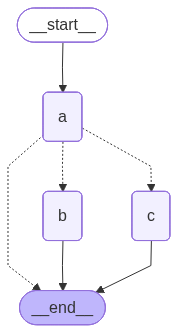

In [6]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# Add edges
builder.add_edge(START, "a")
builder.add_edge("b", END)
builder.add_edge("c", END)
builder.add_conditional_edges("a", conditional_edge)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

<a id='l3_graph'></a>


In [10]:
user = input('b, c, or q to quit: ')

input_state = State(
    nlist = [user]
)
graph.invoke(input_state)

{'nlist': ['quit']}

<a id='l3_execution'></a>


In [11]:
while True:
    user = input('b, c, or q to quit: ')
    print(user)
    input_state = State(nlist =  [user])
    result = graph.invoke(input_state)
    print( result )
    if result['nlist'][-1] == "q":
        print("quit")
        break

b
{'nlist': ['b', 'B']}
c
{'nlist': ['c', 'C']}
q
{'nlist': ['q']}
quit


## Takeaways

Setup:

- Conditional Routing: [Node_a uses Command](#command_node) to return both state updates and routing decisions
- Alternative Approach: The [conditional_edge function](#conditional_edge_func) separates routing logic from node logic

Execution:

- Based on user input, the [graph dynamically routes](#l3_execution) to node 'b', 'c', or END
- The routing decision reads the last value in state to determine the next node
- Control flow changes based on state without hardcoded paths

Try Next:

- Add a new node 'd' and route to it with a different input value
- Uncomment the add_conditional_edges line to use the alternative routing approach


## Lab 4: Memory
<div style="display:flex; align-items:flex-start;">
  <img src="../assets/Memory.png" width="500" style="margin-right:15px;"/>
</div>

Memory allows graphs to persist state across multiple invocations. By adding a checkpointer, your graph can maintain conversation history or accumulate results over time. This notebook demonstrates how to add memory using `InMemorySaver`.


In [18]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()
config = {"configurable": {"thread_id": "1"}}

<a id='memory_setup'></a>


In [19]:
graph = builder.compile(checkpointer=memory)

<a id='graph_with_memory'></a>


In [23]:
config = {"configurable": {"thread_id": "2"}}
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state, config )
    print( result )
    if result['nlist'][-1] == "q":
        print("quit")
        break

{'nlist': ['c', 'C', 'b', 'B', 'c', 'C', 'q', 'c', 'C']}
{'nlist': ['c', 'C', 'b', 'B', 'c', 'C', 'q', 'c', 'C', 'b', 'B']}
{'nlist': ['c', 'C', 'b', 'B', 'c', 'C', 'q', 'c', 'C', 'b', 'B', 'q']}
quit


<a id='l4_execution'></a>


## Takeaways

Setup:

- [InMemorySaver and `thread_id` config](#memory_setup) enable state persistence across invocations
- Pass the [checkpointer to compile()](#graph_with_memory) to enable memory

Execution:

- Each [invoke with the same `thread_id`](#l4_execution) accesses the same persisted state
- State accumulates across multiple invocations within the same thread
- Different `thread_id`s maintain separate conversation histories

Try Next:

- Run the loop multiple times and observe how nlist grows with each invocation
- Change the `thread_id` to start a fresh conversation with empty state
